In [1]:
from operators import BlockMatrixOperator, BlockTriangularPreconditioner
from tunnel_with_subdomains import load_matrices_from_hdf5, load_vectors_from_hdf5

problem_no = 19
path_to_data = f"exported_data/testrun_{problem_no}/"

# loading
A_blocks = load_matrices_from_hdf5(f"{path_to_data}data_as_blocks.h5")
Ptdiagblocks = load_matrices_from_hdf5(f"{path_to_data}data_diag_preco.h5")
Ptblocks = load_matrices_from_hdf5(f"{path_to_data}data_triang_preco.h5")
rhs_u, rhs_p = load_vectors_from_hdf5(f"{path_to_data}data_rhs.h5")  # each rhs_* is a list of ndarrays
sol_u, sol_p = load_vectors_from_hdf5(f"{path_to_data}data_sol.h5")  # each rhs_* is a list of ndarrays

In [16]:
import numpy as np
from numpy.linalg import norm
from scipy.sparse.linalg import gmres, LinearOperator

A_mat = BlockMatrixOperator(A_blocks)
Pt_inv = BlockTriangularPreconditioner(Ptblocks, False)
# Pt_inv = BlockTriangularPreconditioner(Ptdiagblocks, False)

# Define the preconditioned operator
A = LinearOperator(A_mat.shape, matvec=A_mat)
M = LinearOperator(Pt_inv.shape, matvec=Pt_inv)

In [14]:
def fgmres(A, b, M, maxits=1000, tol=1e-6, x0=None):
    n = len(b)
    x = np.zeros(n) if x0 is None else x0.copy()
    r0 = b - A(x)
    # Initial residual norm
    b_norm = np.linalg.norm(b) or 1.0
    res_norm = np.linalg.norm(r0)
    res_hist = [res_norm / b_norm]
    if res_hist[-1] < tol:
        return x, 0, res_hist
    # Initialize Arnoldi basis containers
    V = np.zeros((n, maxits + 1))    # Krylov basis (unpreconditioned residual vectors)
    H = np.zeros((maxits + 1, maxits))  # Hessenberg matrix
    V[:, 0] = r0 / res_norm
    # Flexible GMRES Arnoldi process
    W_list = []  # store preconditioned basis vectors for solution combination
    g = np.zeros(maxits + 1)
    g[0] = res_norm  # initial residual magnitude
    iters = 0
    for j in range(maxits):
        iters = j + 1
        # Apply (flexible) preconditioner
        w_j = M(V[:, j])
        # Mat-vec product
        u = A(w_j)
        # Arnoldi: orthogonalize u against current basis V[:, :j+1]
        for i in range(j + 1):
            H[i, j] = np.dot(V[:, i], u)
            u -= H[i, j] * V[:, i]
        H[j + 1, j] = np.linalg.norm(u)
        if H[j + 1, j] < 1e-14:      # happy breakdown (u is zero or nearly in span)
            break
        V[:, j + 1] = u / H[j + 1, j]
        # Least-squares solve via Arnoldi (update the residual norm)
        y, *_ = np.linalg.lstsq(H[:j + 2, :j + 1], g[:j + 2], rcond=None)
        res = g[:j + 2] - H[:j + 2, :j + 1].dot(y)
        res_norm = np.linalg.norm(res)
        res_hist.append(res_norm / b_norm)
        # Store preconditioned vector for solution reconstruction
        W_list.append(w_j)
        if res_hist[-1] < tol:
            break
    # Solve least-squares for final y (if not already done above)
    y, *_ = np.linalg.lstsq(H[:iters + 1, :iters], g[:iters + 1], rcond=None)
    # Reconstruct solution: x0 + sum(y_j * w_j)
    for j in range(iters):
        x += y[j] * W_list[j]
    return x, iters, res_hist

In [25]:
import numpy as np


def fgmres(A, b, M, maxits=1000, tol=1e-6, x0=None):
    n = len(b)
    x = np.zeros(n) if x0 is None else x0.copy()

    # Initial residual with left preconditioning: r0 = M(b - A*x)
    r0 = M(b - A(x))
    b_norm = np.linalg.norm(M(b)) or 1.0
    res_norm = np.linalg.norm(r0)
    res_hist = [res_norm / b_norm]

    if res_hist[-1] < tol:
        return x, 0, res_hist

    V = np.zeros((n, maxits + 1))
    H = np.zeros((maxits + 1, maxits))

    V[:, 0] = r0 / res_norm
    g = np.zeros(maxits + 1)
    g[0] = res_norm

    for j in range(maxits):
        # Apply A to basis vector
        u = M(A(V[:, j]))  # Left-preconditioned: M*A*v

        # Arnoldi orthogonalization
        for i in range(j + 1):
            H[i, j] = np.dot(V[:, i], u)
            u -= H[i, j] * V[:, i]

        H[j + 1, j] = np.linalg.norm(u)

        # Check for happy breakdown
        if H[j + 1, j] < 1e-14:
            break

        V[:, j + 1] = u / H[j + 1, j]

        # Solve small least-squares problem
        y, *_ = np.linalg.lstsq(H[:j + 2, :j + 1], g[:j + 2], rcond=None)
        res_norm = np.linalg.norm(g[:j + 2] - H[:j + 2, :j + 1] @ y)
        res_hist.append(res_norm / b_norm)

        if res_hist[-1] < tol:
            break

    # Explicit final solution reconstruction
    iters = j + 1
    dx = V[:, :iters] @ y
    x += dx

    return x, iters, res_hist

In [28]:
iter_list = []
res_list = []
true_res_list = []
err_list = []
Z = None
Z_list = []
x_sol = None

warm_up = 10
maxit = 8

for index in range(716):
    rhs_vec = np.concatenate([rhs_u[index], rhs_p[index]])
    sol_vec = np.concatenate([sol_u[index], sol_p[index]])

    # Define a callback function to store residuals
    # residuals = []
    # def callback(resid):
    #     residuals.append(resid)

    # if index > 0 and res_list[-1] < 1e-10:
    #     maxit -= 1
    # # Solve the system using GMRES
    # x_sol, info = gmres(A, rhs_vec, M=M, rtol=1e-16, maxiter=maxit, callback=callback, x0=x_sol)
    x_sol, num_iterations, residuals = fgmres(A, rhs_vec, M, maxits=30, tol=1e-10, x0=x_sol)
    # Extract number of iterations (info > 0 indicates it stopped at maxit)
    num_iterations = len(residuals)

    iter_list.append(num_iterations)
    res_list.append(norm(M(A(x_sol) - rhs_vec)) / norm(rhs_vec))
    true_res_list.append(norm(M(A(sol_vec) - rhs_vec)) / norm(rhs_vec))
    err_list.append(norm(x_sol - sol_vec) / norm(sol_vec))
    print(f"Index {index}: {iter_list[-1]}, {res_list[-1]}, {err_list[-1]} {true_res_list[-1]}")

Index 0: 1, nan, nan nan
Index 1: 8, 5.248220244707542e-11, 7.719454632567813e-11 1.965473914748658e-10
Index 2: 7, 5.122737088976848e-11, 1.940925056024507e-09 3.339523407675715e-09
Index 3: 7, 3.625904184624697e-11, 1.8971433334813973e-09 2.351867917356734e-09
Index 4: 7, 2.7787766769572554e-11, 1.8449656834776684e-09 1.8003439627162612e-09
Index 5: 7, 2.2475699287983484e-11, 1.7867582112446006e-09 1.4546554994346235e-09
Index 6: 7, 1.880127081666072e-11, 1.725041712967056e-09 1.2194072375410538e-09
Index 7: 7, 1.616863556517483e-11, 1.6622310251575858e-09 1.0496458513276273e-09
Index 8: 7, 1.4136146962263825e-11, 1.6000533919741409e-09 9.217326736164846e-10
Index 9: 7, 1.2538338336722882e-11, 1.5398865039928762e-09 8.221297516480014e-10
Index 10: 7, 1.1240470144231197e-11, 1.4825687393907324e-09 7.425468060425989e-10
Index 11: 7, 1.0151117121687319e-11, 1.428584511508823e-09 6.776283164542869e-10
Index 12: 7, 9.2227696761649e-12, 1.3781755288425285e-09 6.237644858477036e-10
Index 13

KeyboardInterrupt: 

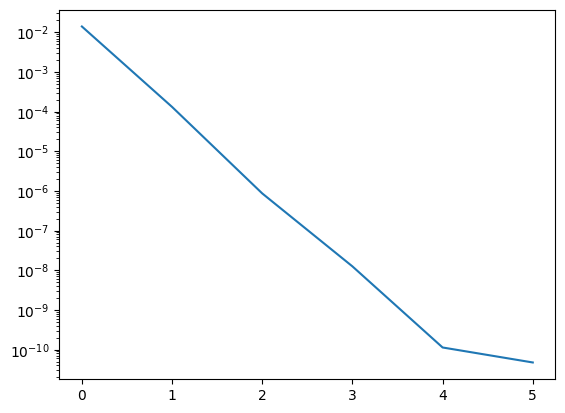

In [29]:
import matplotlib.pyplot as plt
plt.semilogy(residuals)

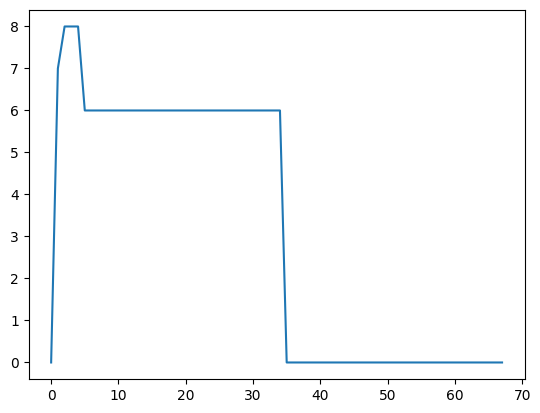

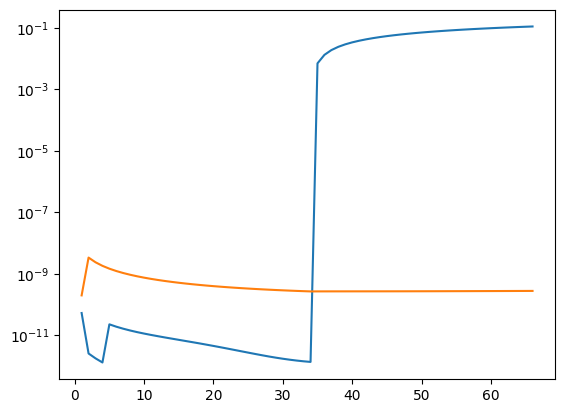

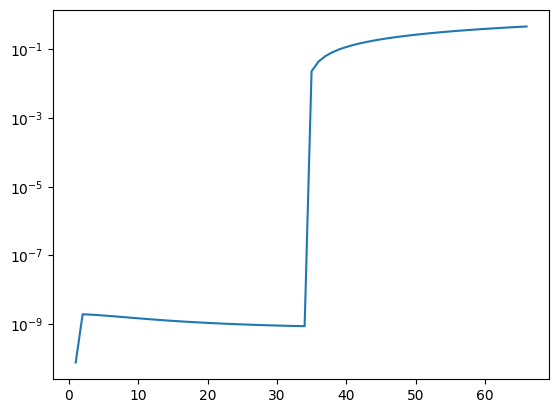

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(iter_list)
plt.show()

plt.figure()
plt.semilogy(res_list)
plt.semilogy(true_res_list)
plt.show()

plt.figure()
plt.semilogy(err_list)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(iter_list)
plt.show()

plt.figure()
plt.semilogy(res_list)
plt.semilogy(true_res_list)
plt.show()

plt.figure()
plt.semilogy(err_list)
plt.show()

In [ ]:
import numpy as np
from scipy.sparse.linalg import gmres, LinearOperator

iter_list = []
res_list = []
true_res_list = []
err_list = []
Z = None
Z_list = []
x_sol = None

warm_up = 716

for index in range(716):
    rhs_vec = np.concatenate([rhs_u[index], rhs_p[index]])
    sol_vec = np.concatenate([sol_u[index], sol_p[index]])
    if index < warm_up:
        x_sol, iters, res_hist = deflated_fgmres(A_mat, rhs_vec, Pt_inv, maxits=30, tol=1e-14, x0 = x_sol)
    else:
        x_sol, iters, res_hist = deflated_fgmres(A_mat, rhs_vec, Pt_inv, maxits=30, tol=1e-14, Z=Z)

    # Z_list.append(x_sol)
    # if index >= (warm_up - 1):
    #     Z = np.column_stack(Z_list[index - (warm_up - 1):])
    #     Z, _ = np.linalg.qr(Z)

    # if Z is None:
    #     if np.linalg.norm(x_sol) > 0:
    #         Z = x_sol / np.linalg.norm(x_sol)
    #         Z = Z.reshape(-1, 1)
    # else:
    #     Z = extend_orthonormal_basis(Z, x_sol.reshape(-1,1), droptol=1e-6, max_size=100, verbose=True)
    #     if index % 100 == 15:
    #         Z, _ = np.linalg.qr(Z)

    iter_list.append(iters)
    res_list.append(np.linalg.norm(A_mat(x_sol) - rhs_vec)/np.linalg.norm(rhs_vec))
    true_res_list.append(np.linalg.norm(A_mat(sol_vec) - rhs_vec)/np.linalg.norm(rhs_vec))
    err_list.append(np.linalg.norm(x_sol - sol_vec)/np.linalg.norm(sol_vec))
    print(f"Inex {index}: {iters}, {np.linalg.norm(A_mat(x_sol) - rhs_vec)/np.linalg.norm(rhs_vec)}, {np.linalg.norm(x_sol - sol_vec)/np.linalg.norm(sol_vec)} {np.linalg.norm(A_mat(sol_vec) - rhs_vec)/np.linalg.norm(rhs_vec)}")

print(f"Number of iterations: {iters}")
print(f"Relative residual: {res_hist[-1]}")
print(f"Relative error: {np.linalg.norm(x_sol - sol_vec)/np.linalg.norm(sol_vec)}")

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(iter_list)
plt.show()

plt.figure()
plt.semilogy(res_list)
plt.semilogy(true_res_list)
plt.show()

plt.figure()
plt.semilogy(err_list)
plt.show()